In [4]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

countries = CountryMetaDataFile().readMetadata()
dl = DataLib("SignalData")

In [26]:
# Setting up Bond Return Index variables
BondReturnIndex = dl.pull('BondRetIdx/LocalFX') # daily, represents accumulated returns from holding 10-year bonds
average = 'Equal Weighted Mean'
std = 'Equal Weighted Std'
BondReturnIndex[average] = BondReturnIndex.mean(axis=1) # global average
MonthlyBondReturnIndex = BondReturnIndex.resample('1M').mean()
MonthlyBondReturnIndex[average] = MonthlyBondReturnIndex.mean(axis=1) # global average

# Indicator 1: Bond Premium

* What it is: difference between the long rate and short rate
* What it means: reflects the slope of the yield curve
* What it tells us: the greater the bond premium, the greater the spread between long and short rates
* What we expect: typically the bond premium is positive (meaning that long rates > short rates) since there is more risk associated with holding bonds for longer
* What this tells us about bonds: steepening yield curves attracts investors with long positions

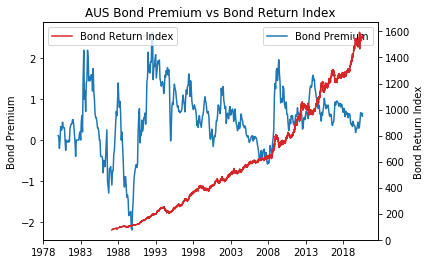

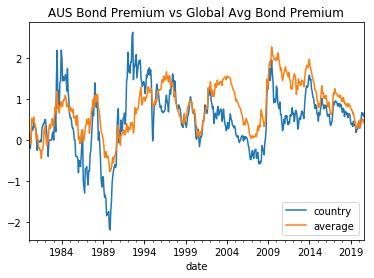

In [69]:
# Calculating Bond Premium for all countries
ShortRates = dl.pull('ShortRates') # monthly
LongRates = dl.pull('LongRates') # monthly, nominal yield on 10-year govenment issued bonds
BondPremium = LongRates - ShortRates
BondPremium[average] = BondPremium.mean(axis=1) # global average
BondPremium[std] = BondPremium.std(axis=1) # global std

country = 'AUS'

# Bond Premium vs. Bond Returns
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Premium'
ax1.plot(BondPremium[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Return Index'
ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Premium vs Bond Return Index')
plt.show()

# Bond Premium vs. Global Avg Bond Premium
BondPremium[country].plot()
BondPremium[average].plot()
plt.legend(['country', 'average'])
plt.title(f'{country} Bond Premium vs Global Avg Bond Premium')
plt.show()

In [83]:
# Calculate and display P&L values from prediction dataframe
def PnLAnalysis(data, country):
    
    # Calculate P&L by re-ranging indicators to fall between -1 and 1
    data['pnlA'] = np.tanh(data['IndicatorA']) * data[country].shift(1).pct_change()
    data['pnlB'] = np.tanh(data['IndicatorB']) * data[country].shift(1).pct_change()
    data['pnlC'] = np.tanh(data['IndicatorC']) * data[country].shift(1).pct_change()
    
    # Plot P&L Curves
    data['pnlA'].cumsum().plot()
    data['pnlB'].cumsum().plot()
    data['pnlC'].cumsum().plot()
    plt.legend(['pnlA', 'pnlB', 'pnlC'])
    plt.title(f'{country} P&L Curves')
    plt.show()
    
    return data

# LOGIC
* The bigger the Bond Premium, the steeper the yield curve, the bigger our long position
* If the Bond Premium is relatively bigger, our position should be positive (long)
* Curve is steepening if premium at given day is greater than some rolling average
* We can scale our Bond Premium by whether or not it is steepening before standardizing

In [84]:
# Takes in a country and returns prediction dataframe
def BondPremiumIndicator(country):
    
    # Set up monthly country data
    data = pd.DataFrame(MonthlyBondReturnIndex[country])
    data['BondPremium'] = BondPremium[country]
    
    # Prediction A: Prediction scaled by domestic change in BP over 6-month period
    # Standardize this month's BP relative to past BP within country withing 6M window
    data['IndicatorA'] = (data['BondPremium'] - data['BondPremium'].rolling(4*12).mean()) / data['BondPremium'].rolling(4*12).std() 
        
    # Prediction B: Prediction scaled by global average
    data['GlobalAvg'] = BondPremium[average]
    data['GlobalStd'] = BondPremium[std]
    data['IndicatorB'] = (data['BondPremium'] - data['GlobalAvg']) / data['GlobalStd'] 

    # Prediction C: Prediction scaled by global average
    # Standardize this month's BP relative to past BP global average withing 6M window
    data['IndicatorC'] = (data['BondPremium'] - data['GlobalAvg'].rolling(4*12).mean()) / data['GlobalAvg'].rolling(4*12).std() 

    # Calculate P&L
    data = PnLAnalysis(data, country)
    
    return data

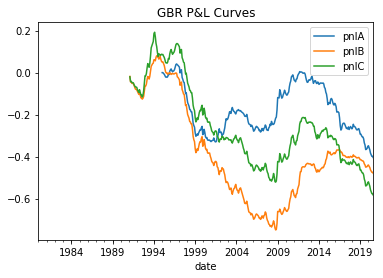

date
1980-01         NaN
1980-02         NaN
1980-03         NaN
1980-04         NaN
1980-05         NaN
1980-06         NaN
1980-07         NaN
1980-08         NaN
1980-09         NaN
1980-10         NaN
1980-11         NaN
1980-12         NaN
1981-01         NaN
1981-02         NaN
1981-03         NaN
1981-04         NaN
1981-05         NaN
1981-06         NaN
1981-07         NaN
1981-08         NaN
1981-09         NaN
1981-10         NaN
1981-11         NaN
1981-12         NaN
1982-01         NaN
1982-02         NaN
1982-03         NaN
1982-04         NaN
1982-05         NaN
1982-06         NaN
             ...   
2018-03   -1.290468
2018-04   -1.740778
2018-05   -1.451830
2018-06   -1.375090
2018-07   -1.630199
2018-08   -1.478002
2018-09   -1.151680
2018-10   -0.838914
2018-11   -1.043558
2018-12   -1.366742
2019-01   -1.560186
2019-02   -1.610219
2019-03   -1.483115
2019-04   -1.800628
2019-05   -1.600540
2019-06   -1.909821
2019-07   -2.113435
2019-08   -2.124399
2019-09   -2.22

In [87]:
results = BondPremiumIndicator('GBR')

In [ ]:
# Test all countries
def TestAll():
    
    all_countries = BondPremium.columns

    for i in all_countries:
        